# I. Introduction

This exercise explores the Big O of our first graph search function, Breadth-First (BF) Search.

First we import helpful packages.

In [1]:
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from faker import Faker
%matplotlib notebook

# II. Generating the Test Data

I chose to generate the test data in a somewhat convulated/tedious way, the rationale being that I wanted to have duplicates (only within levels and never connected to the same person on the next lower level) to create more interesting -- and realistic -- data to test the BF search on.

I also discovered the faker package for this assignment which uses US Census data to help generate random _realistic_ names instead of random character strings.

First, I generated a pool of names from which to source each of my graph's levels.  I generated more names than I would need, but also discovered that faker will produce _some_ duplicates when generating a list of names this size.

In [2]:
'''each additive value below 
represents the number of names needed for the respective graph levels 
if every person in the graph was unique'''
num_names_needed = 5 + 5**2 + 5**3 + 5**4 + 5**5 
num_names_needed

3905

And now to generate the list of names to pool from

In [3]:
fake = Faker()
fake.seed(7)
names = [fake.name() for _ in range(num_names_needed)]
# checking
names[0:2]

['Chris Curtis', 'Joshua Diaz']

The following code uncovered duplicates in the generated values.

In [4]:
print(len(names))
print(len(set(names)))

3905
3772


To subsequently construct the graph levels in a clean and systematic way (to ensure adherence to the assignment specifications), I chose to de-dupe this 'pool' of names.

In [5]:
names = list(set(names))
len(names)

3772

Next I determined the number of unique persons for each level, aribtrarily adding a few duplicates to each.

In [6]:
lev_1_size = 5
lev_2_size = lev_1_size*5 - 2 # 2 dupes in level 2
lev_3_size = lev_2_size*5 - 4 # 4 additional dupes
lev_4_size = lev_3_size*5 - 16 # 16 additional dupes in level 4
lev_5_size = lev_4_size*5 - 64 # 64 additional dupes in level 5

# confirming that the number of unique names I need per the sizes above does not exceed the size of the names 'pool' I created
lev_1_size + lev_2_size + lev_3_size + lev_4_size + lev_5_size <= len(names)

True

Next, I generated lists of unique persons for each graph level by splicing our original pool of names per the graph level 'unique' sizes generated above.

In [7]:
# used some odd space formatting to make the list splicing easier to check
first_lev  = names[                                           :lev_1_size]
second_lev = names[lev_1_size                                 :lev_1_size+lev_2_size]
third_lev  = names[lev_1_size+lev_2_size                      :lev_1_size+lev_2_size+lev_3_size]
fourth_lev = names[lev_1_size+lev_2_size+lev_3_size           :lev_1_size+lev_2_size+lev_3_size+lev_4_size]
fifth_lev  = names[lev_1_size+lev_2_size+lev_3_size+lev_4_size:lev_1_size+lev_2_size+lev_3_size+lev_4_size+lev_5_size]
# checking
print(lev_1_size == len(first_lev))
print(lev_2_size == len(second_lev))
print(lev_3_size == len(third_lev))
print(lev_4_size == len(fourth_lev))
print(lev_5_size == len(fifth_lev))

True
True
True
True
True


To round out my list of names for each level, here is where I add the 'dupes' per level, appending them to the end each level's list.  Appending them to the the end of the respective levels' lists is necessary to avoid potential duplicate connections to the same person on the next lower level, as will become clear when the graph is constructed.

In [8]:
second_lev = second_lev + second_lev[:2]
third_lev = third_lev + third_lev[:4]
fourth_lev = fourth_lev + fourth_lev[:16]
fifth_lev = fifth_lev + fifth_lev[:64]
# checkin the final list sizes for each level, accounting for the generated dupes in lower levels
print(len(first_lev) == 5)
print(len(second_lev) == 5*len(set(first_lev)))
print(len(third_lev) == 5*len(set(second_lev)))
print(len(fourth_lev) == 5*len(set(third_lev)))
print(len(fifth_lev) == 5*len(set(fourth_lev)))

True
True
True
True
True


Now that we have all the names apportioned properly, it's time to create the graph!

In [9]:
# instantiates an empty graph
people_graph = {}

Per the primary use cases of graph searching, we typically want to begin searching from a specific starting point, in our case, level '0' (i.e. searching through my friends network on Facebook requires me to start with my own profile account)

In [10]:
# a generic-ly named starting point
people_graph['level_0_start'] = list(first_lev)

Next we'll loop through the level 1 names and assign them a list of 5 connections each, again using list splicing.

In [11]:
# there are 2 dupes in the second level 
# but dupes will never be connected to the same person in the previous level
# because the lists of names for each level are orderd
# and assigned as connections to persons in the next lower level in the same order as the source names list
# with each dupe appearing exactly once at the beginning of the level's names list and once at the end
for i in range(len(first_lev)):
  people_graph[first_lev[i]] = second_lev[5*i:5*i+5]

The following code finishes creating the rest of the connections in the graph.  

Note that we only want to assign the 5 connections to each person in the graph once, so for each subsequent level (after level 1 above which has no dupes), we'll de-dupe the level's source name list first, before we generate the connections for each person in that level.

In [12]:
second_lev = list(dict.fromkeys(second_lev)) # preserves order vs using set.  not that it matters much
for i in range(len(second_lev)):
  people_graph[second_lev[i]] = third_lev[5*i:5*i+5]

third_lev = list(dict.fromkeys(third_lev)) # preserves order vs using set.  not that it matters much
for i in range(len(third_lev)):
  people_graph[third_lev[i]] = fourth_lev[5*i:5*i+5]

fourth_lev = list(dict.fromkeys(fourth_lev)) # preserves order vs using set.  not that it matters much
for i in range(len(fourth_lev)):
  people_graph[fourth_lev[i]] = fifth_lev[5*i:5*i+5]

Though not really necessary, to again make a graph a touch more realistic, you can't be connected to a person who isn't a node in the graph (i.e. on Facebook, you can only be friends with people who have Facebook accounts).

Thus, let's imagine all the level 5 people have 'accounts with no friends' vs. 'not having accounts'.

In [13]:
fifth_lev = list(dict.fromkeys(fifth_lev)) # preserves order vs using set.  not that it matters much
for i in range(len(fifth_lev)):
  people_graph[fifth_lev[i]] = []

Now we'll run a few checks to ensure the graph was created as intended.

In [14]:
# checking that the graph has the expected number of dictionary keys/graph nodes
print(len(people_graph) == lev_1_size + lev_2_size + lev_3_size + lev_4_size + lev_5_size + 1) 
# the '+1' above is for the level0 start node

True


In [15]:
# checking to see that each person/node has 0 connection dupes
true_counter = 0 
for i in people_graph.keys():
  true_counter = true_counter + (len(people_graph[i]) == len(set(people_graph[i])))

print(true_counter == len(people_graph))

True


All set!

Lastly, we just need to (randomly) generate the list of persons we eventually want to search for within our newly created graph.

In [16]:
people_to_search_for = []
random.seed(7)

# append the element of a random index from the 1st level names
people_to_search_for.append(first_lev[random.randint(0,lev_1_size-1)])

# append the elements of 2 random indexes from the 2nd level names
people_to_search_for += [second_lev[i] for i in random.sample(range(lev_2_size), 2)]

# append the elements of 3 random indexes from the 3rd level names
people_to_search_for += [third_lev[i] for i in random.sample(range(lev_3_size), 3)]

# append the elements of 4 random indexes from the 4th level names
people_to_search_for += [fourth_lev[i] for i in random.sample(range(lev_4_size), 4)]

# append the elements of 5 random indexes from the 5th level names
people_to_search_for += [fifth_lev[i] for i in random.sample(range(lev_5_size), 5)]

In [17]:
# checking
print(len(set(people_to_search_for))) # no dupes?
print(len(people_to_search_for))
people_to_search_for

15
15


['Anthony Robinson',
 'Ms. Kari Merritt',
 'Brandon Scott',
 'David Villarreal',
 'Brett Mcintyre',
 'Melissa Monroe',
 'Allison Watkins',
 'Alan Padilla',
 'Mary Lewis',
 'Christopher Baker',
 'Robert Baker',
 'Robert Kelley',
 'Christopher Powell',
 'Laura Ward PhD',
 'Aaron Barnes']

# III. Defining the Breadth-First Search Function

Next I started with the source code provide by our textbook and with a bit of testing and troubleshooting, added both a 'level' or 'degree' counter, as well as a 'token' that will indicate to us when to increment the degree counter.

In [18]:
def breadth_first_search(starter_name, search_for_name):
    # instantiates a 'degree' counter to track how far into the graph we're currently searching
    degree_counter = 1
    # creates a 'token' that will get fed through the data structures to indicate to us when to increment the degree counter
    degree_incre_token = 'Degree Increment Token Here!'
    
    # instantiates the list to keep tracking of who we've already searched for
    # since we never need to check if 'Degree Increment Token Here!' == the person we're searching for
    # we can add the token to 'searched' to avoid ever checking it
    searched = [degree_incre_token] 
    
    # instantiates a list to keep tracking of who we have to search
    # first we add the starter node's connections
    to_search = list(people_graph[starter_name])
    
    # then we append the token (after all the first level connections)
    # now when we reach the token (just before any second level connections), we know to increment our degree counter
    to_search.append(degree_incre_token)
    
    # and here is where our search begins
    while to_search:
        person = to_search.pop(0)
        if person == degree_incre_token:
            degree_counter += 1
            # when we reach the token, we know we've finished searching level 'a' (whose connections are 'b') 
            # and are about to start search level 'b' (whose connections are 'c')
            # so before we add any level 'c' connections from searching the level 'b's, 
            # we'll add the token to the 'to_search' list again so if/when we find it again, 
            # we know we're about to start search the next level and it's time to increment the degree counter again
            to_search.append(person) 
        if person not in searched: # since the token is in searched, when it's the current 'person' we'll skip this next section
            if person == search_for_name:
                return degree_counter
                #return("We found " + person + "!  They are in level " + str(degree_counter) + " of the graph.")
            else:
                searched.append(person)
                to_search += list(people_graph[person])
    return False # if to_search is empty without previous return
  #return("Can't find " + search_for_name + ".  :(")

And now for a quick test to ensure our BF search function works as expected.

In [19]:
for i in people_to_search_for:
  print(breadth_first_search('level_0_start', i))

1
2
2
3
3
3
4
4
4
4
5
5
5
5
5


Looks good.

# IV. Time Testing

First I instantiated a list to capture the results of the time testing

In [20]:
results = []

Now, I define a function to conduct the time testing

In [21]:
def graph_time_testing(name_to_search):
  start = time.perf_counter()
  graph_level = breadth_first_search('level_0_start', name_to_search)
  end = time.perf_counter()
  search_time = (end - start)*1000
  results.append({'Name':name_to_search
                      ,'Graph Level/Degree of Person Found':graph_level
                      ,'Search Time in ms':search_time})

Finally, I run the time testing...

In [22]:
for i in people_to_search_for:
  graph_time_testing(i)

... and organize the results into pandas dataframe for easier exploration and visualization

In [23]:
results_df = pd.DataFrame(results)

# V. Results Exploration & Visualization

Firstly, our results are small enough that we can just take a look at the raw data is to get an initial take on the BF search times.

In [24]:
results_df

,Graph Level/Degree of Person Found,Name,Search Time in ms
0,1,Anthony Robinson,0.0101
1,2,Ms. Kari Merritt,0.0153
2,2,Brandon Scott,0.0259
3,3,David Villarreal,0.2759
4,3,Brett Mcintyre,0.0841
5,3,Melissa Monroe,0.1400
6,4,Allison Watkins,0.9068
7,4,Alan Padilla,3.7083
8,4,Mary Lewis,0.6318
9,4,Christopher Baker,6.5468


Based on an initial look, it's clear that on average, BF search times increase with each level of the graph being where the person/name was found.  (No surprise).

Lastly, we graph the results looking at categorical scatterplots of the data.

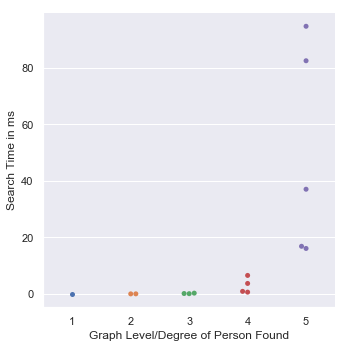

In [25]:
sns.set(style="darkgrid")
sns.catplot(x="Graph Level/Degree of Person Found", y="Search Time in ms"
            , hue = "Graph Level/Degree of Person Found", data=results_df, kind='swarm')

Curious about the results with different random names tested, I decided to create a few additional lists of people to search for, run the time testing again for each additional list, and append the new results.

In [26]:
few_seeds = [10, 123, 777]

for i in few_seeds:
    people_to_search_forV2 = []
    random.seed(i)

    # append the element of a random index from the 1st level names
    people_to_search_forV2.append(first_lev[random.randint(0,lev_1_size-1)])

    # append the elements of 2 random indexes from the 2nd level names
    people_to_search_forV2 += [second_lev[i] for i in random.sample(range(lev_2_size), 2)]

    # append the elements of 3 random indexes from the 3rd level names
    people_to_search_forV2 += [third_lev[i] for i in random.sample(range(lev_3_size), 3)]

    # append the elements of 4 random indexes from the 4th level names
    people_to_search_forV2 += [fourth_lev[i] for i in random.sample(range(lev_4_size), 4)]

    # append the elements of 5 random indexes from the 5th level names
    people_to_search_forV2 += [fifth_lev[i] for i in random.sample(range(lev_5_size), 5)]

    for i in people_to_search_forV2:
      graph_time_testing(i)

Now let's plot the complete set of results data points.

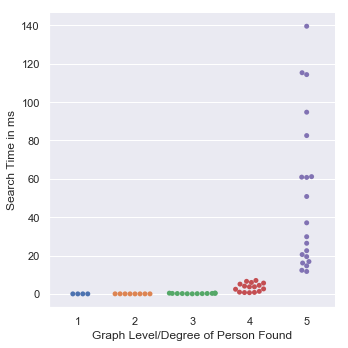

In [27]:
results_dfV2 = pd.DataFrame(results)

sns.set(style="darkgrid")
sns.catplot(x="Graph Level/Degree of Person Found", y="Search Time in ms"
            , hue = "Graph Level/Degree of Person Found", data=results_dfV2, kind='swarm')

For one final plot, to better see a potential discrepency in run times among the first 4 levels of where the names are found, I'll exclude people of degree 5 and replot.

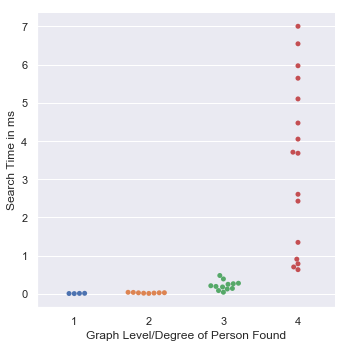

In [28]:
sns.set(style="darkgrid")
sns.catplot(x="Graph Level/Degree of Person Found", y="Search Time in ms"
            , hue = "Graph Level/Degree of Person Found", kind='swarm'
            , data=results_dfV2[results_dfV2["Graph Level/Degree of Person Found"] < 5])

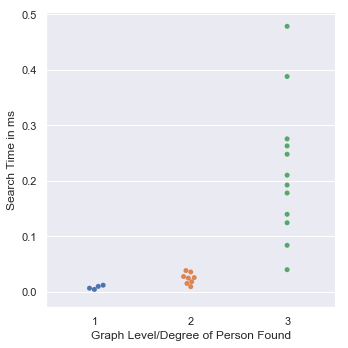

In [29]:
sns.set(style="darkgrid")
sns.catplot(x="Graph Level/Degree of Person Found", y="Search Time in ms"
            , hue = "Graph Level/Degree of Person Found", kind='swarm'
            , data=results_dfV2[results_dfV2["Graph Level/Degree of Person Found"] < 4])

# VI. Executive Summary

Clearly as the connection degree of the person we're searching for (in comparison to our starting node) increases, so does the time it takes to find said person.

However, there is also relatively large variation in search time among names/people in the same graph level.  We can see this by looking at the vertical spread of the data points within the highest graph level/degree plotted.  This is more noticeable the larger that graph level is (and for us, our graph levels are increasing in size exponentially).

Lastly, one more thing to note is the y-axis scale.  Without paying close attention, one might percieve all the graphs as if they're on the same scale.  However even among the first two figures (both plotting through graph level/degreee 5) the y-axis scale grows from 0-90 to 0-140.  The more random names from graph level 5 that we choose to search for, the more likely we'll end up searching for a name that gets appended to our 'to_search' list toward the end of the list of all level 5 connections, increasing the maximum BF search time among our test search population... and thus automatically increasing the plots' y-axis scale.